# Classifier for game sales

This classifier predicts whether a video game will have a high, or low global sales based on the inputs given by the user such as:

- Platform: The platform on which the game will be released (e.g., PS2, X360, PS3, Wii, etc.).
- Year of Release: The year in which the game will be released.
- Genre: The genre of the video game (e.g., Action, Adventure, Sports, etc.).
- Publisher: The company responsible for publishing the game.
- Developer: The company responsible for developing the game.
- Critic Score and counts: The average score given and the number of professional critics who review the games.
- User Score and counts: The average score given and the number of users.
- Rating: The rating of the game (e.g., E, T, M, etc.).

This classification model is useful to simulate what a game with certian features/characteritics would sell for, that is if it would have a reasonable sales globally.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib
import warnings
warnings.filterwarnings('ignore')

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\USER\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
games = pd.read_csv('Data/cleaned_df')
games.head()

,name,platform,year_of_release,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count,developer,rating,release_era
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.00,322.0,Others,E,2000-2010
1,Super Mario Bros.,Others,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,74.2,28.8,6.24,1448.2,missing,missing,pre-2000s
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.30,709.0,Others,E,2000-2010
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.00,192.0,Others,E,2000-2010
4,Pokemon Red/Pokemon Blue,Others,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,90.0,9.0,8.74,817.4,missing,missing,pre-2000s


In [3]:
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'publisher', 'na_sales',
       'eu_sales', 'jp_sales', 'other_sales', 'global_sales', 'critic_score',
       'critic_count', 'user_score', 'user_count', 'developer', 'rating',
       'release_era'],
      dtype='object')

In [4]:
games['global_sales'].describe()

count    16713.000000
mean         0.533568
std          1.548125
min          0.010000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.530000
Name: global_sales, dtype: float64

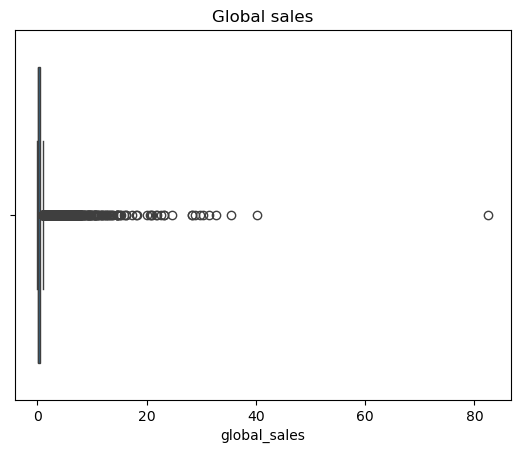

In [5]:
sns.boxplot(data=games, x='global_sales')
plt.title('Global sales')
plt.show()

In [6]:
#we group the sales into two categories - high, and low

def sale_category(global_sales):
    if global_sales < 1:
        return 'Low'
    else:
        return 'High'
    
games['global_sale_cat'] = games['global_sales'].apply(sale_category)
games.head()

,name,platform,year_of_release,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count,developer,rating,release_era,global_sale_cat
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.00,322.0,Others,E,2000-2010,High
1,Super Mario Bros.,Others,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,74.2,28.8,6.24,1448.2,missing,missing,pre-2000s,High
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.30,709.0,Others,E,2000-2010,High
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.00,192.0,Others,E,2000-2010,High
4,Pokemon Red/Pokemon Blue,Others,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,90.0,9.0,8.74,817.4,missing,missing,pre-2000s,High


In [7]:
#dropping irrelevant columns

games.drop(['name', 'year_of_release', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales'], axis=1, inplace=True)
games.head()

,platform,genre,publisher,critic_score,critic_count,user_score,user_count,developer,rating,release_era,global_sale_cat
0,Wii,Sports,Nintendo,76.0,51.0,8.00,322.0,Others,E,2000-2010,High
1,Others,Platform,Nintendo,74.2,28.8,6.24,1448.2,missing,missing,pre-2000s,High
2,Wii,Racing,Nintendo,82.0,73.0,8.30,709.0,Others,E,2000-2010,High
3,Wii,Sports,Nintendo,80.0,73.0,8.00,192.0,Others,E,2000-2010,High
4,Others,Role-Playing,Nintendo,90.0,9.0,8.74,817.4,missing,missing,pre-2000s,High


What we want to find out is that for a game, e.g Mouse tetris published in the post-2010 era, on Wii platform with all the other properties what kind of sales would it turn in - high, or low sales.

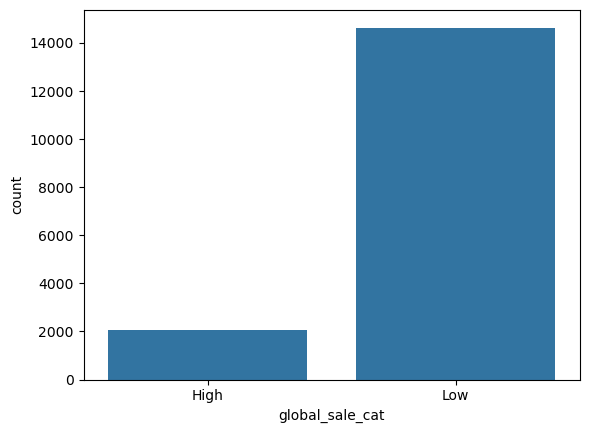

In [8]:
# distribution of our target variable
sns.countplot(x='global_sale_cat', data = games)
plt.show()

This shows a case of data balance where data is skewed in favour of the lower sales cases. In an imbalanced dataset like this, the classifier might learn to predict the majority class more often simply because it is more prevalent. This would lead to higher accuracy but poor performance on the minority class.

I addressed this using balanced weights that help to adjust the loss function used during training. When a minority class instance is missclassified, the penalty is higher, forcing the model to learn features that better distinguish minority class instances.

In [9]:
#extracting dummy variables

games = pd.get_dummies(games, columns=['platform','genre','publisher', 'developer','rating','release_era'])
def change_datatype(data):
    for col_name in data.columns:
        if data[col_name].dtype == 'bool':
            data[col_name]=data[col_name].astype(int)
    return data

games = change_datatype(games)
games.dtypes

critic_score                              float64
critic_count                              float64
user_score                                float64
user_count                                float64
global_sale_cat                            object
platform_DS                                 int32
platform_Others                             int32
platform_PC                                 int32
platform_PS                                 int32
platform_PS2                                int32
platform_PS3                                int32
platform_PSP                                int32
platform_Wii                                int32
platform_X360                               int32
platform_XB                                 int32
genre_Action                                int32
genre_Adventure                             int32
genre_Fighting                              int32
genre_Misc                                  int32
genre_Platform                              int32


In [10]:
#identifying input and output variables

X = games.drop(columns=['global_sale_cat'])
y = games['global_sale_cat']

In [11]:
#data preparation - splitting into train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(13370, 58) (3343, 58)
(13370,) (3343,)


In [12]:
from sklearn.preprocessing import MinMaxScaler

#data preprocessing for X_train
x_scaler = MinMaxScaler()

#rescaling the train data
X_train[['critic_score', 'critic_count','user_score','user_count']] = x_scaler.fit_transform(X_train[['critic_score', 'critic_count','user_score','user_count']])

In [13]:
#rescaling the test data

X_test[['critic_score', 'critic_count','user_score','user_count']] = x_scaler.transform(X_test[['critic_score', 'critic_count','user_score','user_count']])

In [14]:
##save the scaler for later use when integrating in Streamlit
joblib.dump(x_scaler, 'scaler.pkl')

['scaler.pkl']

In [15]:
##save the training columns
joblib.dump(X_train.columns, 'columns.pkl')

['columns.pkl']

### 1. Logistic regression

In [16]:
##a. training the model 

from sklearn.linear_model import LogisticRegression
classifier1 = LogisticRegression(max_iter=200, class_weight='balanced')
classifier1.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=200)

In [17]:
#performing cross-validation for LR()

k=5
cv_scores1 =cross_val_score(classifier1, X,y, cv=k, scoring='accuracy')
avg_cv1 = round(np.mean(cv_scores1), 2)
std_cv1 = round(np.std(cv_scores1), 2)
print(cv_scores1, avg_cv1, std_cv1)

[0.49356865 0.69099611 0.8040682  0.83901855 0.89437463] 0.74 0.14


This shows the distribution of the cv scores across various k-folds. It also shows the average cv score and the standard variation.

In [18]:
##b. predictng the values of y using the training data
y_train_pred = classifier1.predict(X_train)

##c. predicting the values of y using the test data
y_test_pred = classifier1.predict(X_test)

In [19]:
##d. Evaluating on train data to find the accuracy
train_acc_score = accuracy_score(y_train, y_train_pred)
print(train_acc_score)

0.7634255796559462


In [20]:
##e. Evaluating on test data to find the accuracy
test_acc_score = accuracy_score(y_test, y_test_pred)
print(test_acc_score)
print(classification_report(y_test, y_test_pred))

#classification reports provide a detailed view of the performance metrics of the model

0.759198324857912
              precision    recall  f1-score   support

        High       0.30      0.75      0.43       399
         Low       0.96      0.76      0.85      2944

    accuracy                           0.76      3343
   macro avg       0.63      0.75      0.64      3343
weighted avg       0.88      0.76      0.80      3343



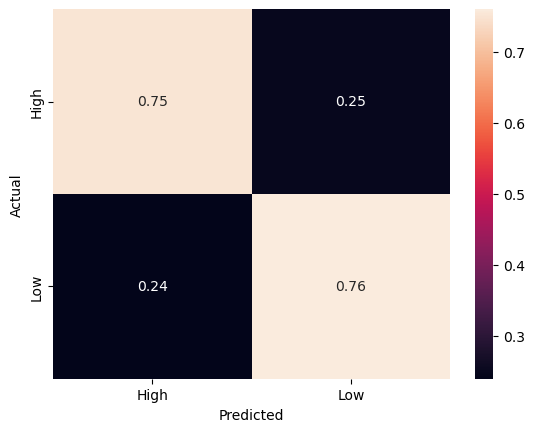

In [21]:
#for the test data
confusion_matrix(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier1.classes_, yticklabels=classifier1.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#the confusion matrix provides a view of the distribution of the true positives & negatives, false positives and negatives

This visual shows us that the model correctly predicts Low sales cases 76% of the times (True positives) whereas its incorrect predictions (False negatives) are made 24% of the times. The same applies to high sales where correct predictions are made 75% of the time and 25% wrong predictions.

### 2. Random forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
classifier2 = RandomForestClassifier(class_weight='balanced')
classifier2.fit(X_train, y_train)

#we set class weight to give higher weight to the minority class and help the model to pay more attention to it

RandomForestClassifier(class_weight='balanced')

In [23]:
#performing cross-validation for RF()

k=5
cv_scores2=cross_val_score(classifier2, X,y, cv=k, scoring='accuracy')
avg_cv2 = round(np.mean(cv_scores2), 2)
std_cv2 = round(np.std(cv_scores2), 2)
print(cv_scores2, avg_cv2, std_cv2)

[0.80257254 0.87556087 0.90008974 0.88659485 0.88689408] 0.87 0.03


In [24]:
y_train_pred = classifier2.predict(X_train)
y_test_pred = classifier2.predict(X_test)

In [25]:
#evaluating on train data
train_acc_score2 = accuracy_score(y_train, y_train_pred)
print(train_acc_score2)

0.9673896783844428


In [26]:
#evaluating on the test data
test_acc_score2 = accuracy_score(y_test, y_test_pred)
print(test_acc_score2)
print(classification_report(y_test, y_test_pred))

0.8965001495662579
              precision    recall  f1-score   support

        High       0.58      0.47      0.52       399
         Low       0.93      0.95      0.94      2944

    accuracy                           0.90      3343
   macro avg       0.76      0.71      0.73      3343
weighted avg       0.89      0.90      0.89      3343



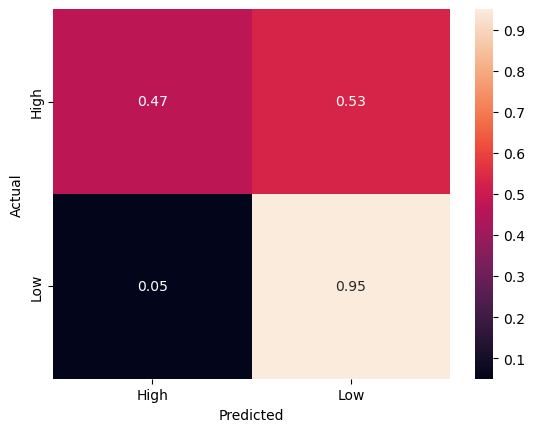

In [27]:
#for the test data
confusion_matrix(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier2.classes_, yticklabels=classifier2.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 3. Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier
classifier3 = DecisionTreeClassifier(class_weight='balanced', random_state=42)
classifier3.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [29]:
#performing cross-validation for NB()

k=5
cv_scores3=cross_val_score(classifier3, X,y, cv=k, scoring='accuracy')
avg_cv3 = round(np.mean(cv_scores3), 2)
std_cv3 = round(np.std(cv_scores3), 2)
print(cv_scores3, avg_cv3, std_cv3)

[0.71731977 0.81184565 0.86838169 0.85667265 0.85876721] 0.82 0.06


In [30]:
y_train_pred = classifier3.predict(X_train)
y_test_pred = classifier3.predict(X_test)

In [31]:
train_acc_score3 = accuracy_score(y_train, y_train_pred)
print(train_acc_score3)

0.9584891548242334


In [32]:
test_acc_score3 = accuracy_score(y_test, y_test_pred)
print(test_acc_score3)
print(classification_report(y_test, y_test_pred))

0.8480406820221358
              precision    recall  f1-score   support

        High       0.40      0.55      0.46       399
         Low       0.94      0.89      0.91      2944

    accuracy                           0.85      3343
   macro avg       0.67      0.72      0.69      3343
weighted avg       0.87      0.85      0.86      3343



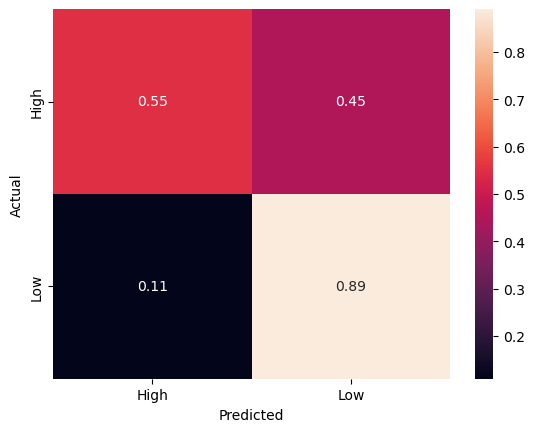

In [33]:
#for the test data
confusion_matrix(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier3.classes_, yticklabels=classifier3.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 4. Support Vector Classifier

In [34]:
from sklearn import svm
classifier4 = svm.SVC(class_weight='balanced')
classifier4.fit(X_train, y_train)

SVC(class_weight='balanced')

In [35]:
#performing cross-validation for SVC()

k=5
cv_scores4=cross_val_score(classifier4, X,y, cv=k, scoring='accuracy')
avg_cv4 = round(np.mean(cv_scores4), 2)
std_cv4 = round(np.std(cv_scores4), 2)
print(cv_scores4, avg_cv4, std_cv4)

[0.63146874 0.76667664 0.82919533 0.80191502 0.75523639] 0.76 0.07


In [36]:
y_train_pred = classifier4.predict(X_train)
y_test_pred = classifier4.predict(X_test)

In [37]:
train_acc_score4 = accuracy_score(y_train, y_train_pred)
print(train_acc_score4)

0.8272999252056844


In [38]:
test_acc_score4 = accuracy_score(y_test, y_test_pred)
print(test_acc_score4)

print(classification_report(y_test, y_test_pred))

0.8055638647921028
              precision    recall  f1-score   support

        High       0.35      0.74      0.48       399
         Low       0.96      0.81      0.88      2944

    accuracy                           0.81      3343
   macro avg       0.65      0.78      0.68      3343
weighted avg       0.89      0.81      0.83      3343



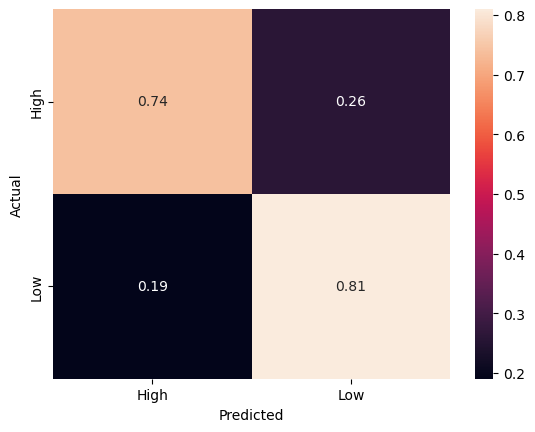

In [39]:
#for the test data
confusion_matrix(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier4.classes_, yticklabels=classifier4.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [40]:
#summary of results
model_results = pd.DataFrame({
                    'Algorithms': ['LR', 'RF', 'DT', 'SVC'],
                    'train_score': [train_acc_score, train_acc_score2, train_acc_score3, train_acc_score4],
                    'test_score': [test_acc_score, test_acc_score2, test_acc_score3, test_acc_score4],
                    'avg_cv': [avg_cv1, avg_cv2, avg_cv3, avg_cv4],
                    'std_cv': [std_cv1, std_cv2, std_cv3, std_cv4]
})
round(model_results, 2)

,Algorithms,train_score,test_score,avg_cv,std_cv
0,LR,0.76,0.76,0.74,0.14
1,RF,0.97,0.90,0.87,0.03
2,DT,0.96,0.85,0.82,0.06
3,SVC,0.83,0.81,0.76,0.07


### How to check whether the models did not overfit?

The train score shows how much learning the model was able to do while the test score provides insight on the capability of the model to predict on unseen data, i.e generalizability. 

**High training score, low test score = Overfitting**

If we have high accuracy on the training set but poor accuracy on the validation/test set, this is a case of overfitting where he model performs well on the training data but poorly on unseen data suggesting that it memorized the training data rather than learning the underlying patterns. The DT and SVC model shows a case of overfitting and is not fit to be used.


**Low training score, low test score = Underfitting**

In this case, the model is too simple to capture the underlying patterns in the data, leading to poor performance on both training and test data.

**Well-balanced model**

Here, the training score is equal to the test score and indicates that the model is performing well without underfitting or overfitting.


### Choosing the best model to use
The significant difference in the training and testing accuracy as can be observed for most models indicate cases of overfit. 

The LR model have similar training and testing accuracy with an average cross-validation score of 75% and a low standard deviation (0.14) indicating consistent and reliable performance across different data splits. **LR is therefore the best performing model.**

In [43]:
#saving the best model

joblib.dump(classifier1, 'LR_model.pkl')

['LR_model.pkl']

#### Some notes:

**1. Confusion matrix**

The confusion matrix is calculated on the test data and not the training data. Why? The test data contains data that the model has never seen before and evaluating the model on this unseen data provides a better estimate of the performance in real-world scenarios and helps us test the data to detect issues such as overfitting. 

It is not used on the training data. Evaluating the confusion matrix on the training set can be misleading as the model has already seen this data and was optimized to perform well on it. The metrics calculated for the training set is often overly optimistic and do not reflect the model's true performance on new data.


**2. Using class_weights**

It handles imbalanced datasets when training a classifier. It adjusts the weights associated, with classes inveresly proportional to their frequencies in the training data.


The weight for each class is calculated as follows:

$$ weight_i = \frac{n_{samples}}{n_{classes} * n_i} $$

For example:

**Class A:** 900 samples

**Class B:** 100 samples

$$Weight \ for \ class \ A: \frac{1000}{2*900} = 0.555$$

$$Weight \ for \ class \ B: \frac{1000}{2*100} = 5$$

These weights are then used by the classifier to balance the impact of each class during the learning process.

**3. Cross-validation**

It is used to evaluate the performance of a model by splitting the data into multiple subsets, then training & testing the model on these subsets multiple times. The most common method involves dividing the data into k equally sized folds - this is known as k-fold cross-validation. You can either print the:

- cv_scores: an array containing the accuracy (or other metric) from each fold
- average: the mean of the cross-validation scores. For example, an avg cv score of 0.96 means that on average the model correctly classifies 96% of the instances.
- std:  measures the variability of the model's performance across different folds. A low std suggests the model performs consistently while a high standard deviation indicates the model's performance is unstable.